In [1]:
import pandas as pd
import numpy as np



In [2]:
data = pd.read_csv('HateSpeechDatasetBalanced.csv')

In [21]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

max_features = 10000
maxlen = 25
embedding_size = 50

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data['Content']))
X = tokenizer.texts_to_sequences(data['Content'])
X = pad_sequences(X, maxlen = maxlen)
y = data['Label']

In [22]:


def load_embeddings(file_path, vocab_size, tokenizer):
    embeddings_dictionary = {}
    embedding_dim = 50  # Assuming 50-dimensional embeddings

    try:
        with open(file_path, encoding="utf8") as glove_file:
            for line in glove_file:
                records = line.split()
                word = records[0]
                vector_dimensions = np.asarray(records[1:], dtype='float32')
                embeddings_dictionary[word] = vector_dimensions
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, index in tokenizer.word_index.items():
        if index < vocab_size:  # Check if the index is within range
            embedding_vector = embeddings_dictionary.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector

    return embedding_matrix

# Usage
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_matrix = load_embeddings('glove.6B.50d.txt', vocab_size, tokenizer)

In [23]:
# Trim the embedding matrix to match max_features
word_index = tokenizer.word_index

num_words = min(max_features, len(word_index) + 1)
embedding_matrix_trimmed = np.zeros((num_words, embedding_size))

for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_matrix[i]
    if embedding_vector is not None:
        embedding_matrix_trimmed[i] = embedding_vector


In [24]:
# Create a Sequential model
model = Sequential()

# Add an Embedding layer with pre-trained weights
model.add(Embedding(max_features, embedding_size, weights=[embedding_matrix_trimmed]))

# Add a Bidirectional LSTM layer with 128 units, returning sequences
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# Add a Global Max Pooling layer to reduce sequence dimension
model.add(GlobalMaxPool1D())

# Add a Dense layer with 40 units and ReLU activation
model.add(Dense(40, activation="relu"))

# Add Dropout for regularization
model.add(Dropout(0.5))

# Add another Dense layer with 20 units and ReLU activation
model.add(Dense(20, activation="relu"))

# Add another Dropout layer
model.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model.add(Dense(1, activation="sigmoid"))

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set training parameters
batch_size = 100
epochs = 5

# Train the model
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 278s 47ms/step - accuracy: 0.7842 - loss: 0.4484 - val_accuracy: 0.6765 - val_loss: 0.7648
Epoch 2/5
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 291s 50ms/step - accuracy: 0.8446 - loss: 0.3484 - val_accuracy: 0.6992 - val_loss: 0.6717
Epoch 3/5
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 321s 55ms/step - accuracy: 0.8594 - loss: 0.3198 - val_accuracy: 0.7416 - val_loss: 0.6145
Epoch 4/5
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 326s 56ms/step - accuracy: 0.8687 - loss: 0.2994 - val_accuracy: 0.6562 - val_loss: 0.7444
Epoch 5/5
5809/5809 ━━━━━━━━━━━━━━━━━━━━ 309s 53ms/step - accuracy: 0.8786 - loss: 0.2789 - val_accuracy: 0.7166 - val_loss: 0.6654


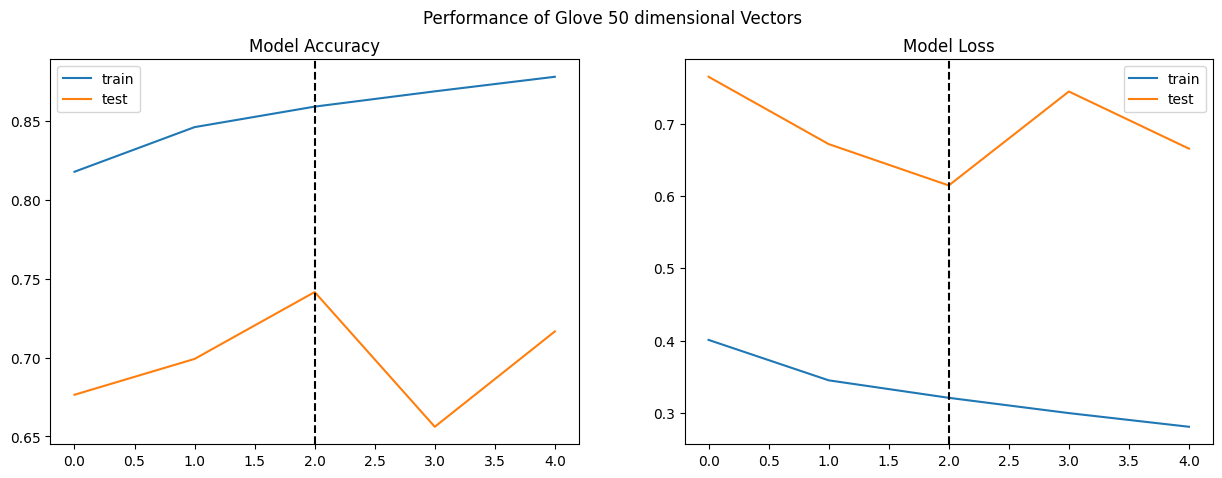

In [25]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Glove 50 dimensional Vectors")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()